In [5]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.image import load_image
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.image_classification.models.darknet19 import DarkNet19FeatureExtractor
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer
from torchlake.common.controller.recorder import TrainRecorder

from torchlake.object_detection.models.yolov2 import YOLOV2, YOLOV2Loss, PriorBox
from torchlake.object_detection.utils.plot import draw_pred

In [6]:
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt

# setting

In [7]:
artifact_path = Path('../../artifacts/yolov2')
artifact_path.mkdir(exist_ok=True)

In [8]:
data_path = Path("../../data/VOCdevkit")

In [9]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 5

In [10]:
CONTEXT = DetectorContext(
    detector_name="yolov2",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("voc.anchors.txt").as_posix(),
)

# data

In [11]:
BATCH_SIZE = 64

In [12]:
IMAGE_SIZE = 416

In [13]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        # A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [14]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [15]:
# train_dataset.env.close()

In [16]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 416, 416]) 1


In [17]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [18]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([64, 3, 416, 416]) 64


# model

If you don't have anchors yet, build one in debug section

In [19]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["3_1", "4_1"])

In [20]:
# backbone = DarkNet19FeatureExtractor("last_conv", "../../artifacts/darknet19/darknet19_448.pth", trainable=False)
# backbone.fix_target_layers(["3_1", "4_1"])

In [21]:
model = YOLOV2(
    backbone,
    CONTEXT,
    backbone.feature_dims[-2:],
).to(CONTEXT.device)

In [22]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV2                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        221,952
│    │    └─Sequential: 3-3                        1,116,416
│    │    └─Sequential: 3-4                        6,822,400
│    │    └─Sequential: 3-5                        13,114,368
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─ModuleDict: 1-2                                  --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-7              8,256
│    │    └─StackedPatch2d: 3-8                    --
│    └─Sequential: 2-4                             --
│    │    └─Conv2dNormActivation: 3-9              4,720,640
│    │    └─Conv2dNormActivation: 3-1

# train

In [23]:
EPOCH = 10

In [24]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [25]:
recorder = TrainRecorder(0, EPOCH, num_loss=1)
recorder.increment_data_size(len(train_dataset))

In [26]:
# underestimate the loss, since we drop last batch
recorder.data_size

16551

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = YOLOV2Loss(CONTEXT)

In [28]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [29]:
scaler = torch.cuda.amp.GradScaler()

In [167]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 258/258 [04:10<00:00,  1.03it/s]


------------------------------------
Epoch 1
------------------------------------
29.902735918672075 (0%)


100%|██████████| 258/258 [04:03<00:00,  1.06it/s]


------------------------------------
Epoch 2
------------------------------------
5.349706026904351 (-82%)


100%|██████████| 258/258 [04:07<00:00,  1.04it/s]


------------------------------------
Epoch 3
------------------------------------
3.9947264007942658 (-25%)


100%|██████████| 258/258 [03:57<00:00,  1.09it/s]


------------------------------------
Epoch 4
------------------------------------
3.2066239387014837 (-20%)


100%|██████████| 258/258 [04:01<00:00,  1.07it/s]


------------------------------------
Epoch 5
------------------------------------
2.7186109100207188 (-15%)


100%|██████████| 258/258 [03:20<00:00,  1.28it/s]


------------------------------------
Epoch 6
------------------------------------
2.3491046507476234 (-14%)


100%|██████████| 258/258 [02:57<00:00,  1.45it/s]


------------------------------------
Epoch 7
------------------------------------
2.05714870321737 (-12%)


100%|██████████| 258/258 [02:52<00:00,  1.50it/s]


------------------------------------
Epoch 8
------------------------------------
1.801534043201961 (-12%)


100%|██████████| 258/258 [02:50<00:00,  1.51it/s]


------------------------------------
Epoch 9
------------------------------------
1.5979362092747864 (-11%)


100%|██████████| 258/258 [02:44<00:00,  1.56it/s]


------------------------------------
Epoch 10
------------------------------------
1.4295950407823694 (-11%)


100%|██████████| 258/258 [02:45<00:00,  1.56it/s]


------------------------------------
Epoch 11
------------------------------------
1.2851828355658386 (-10%)


100%|██████████| 258/258 [02:44<00:00,  1.56it/s]


------------------------------------
Epoch 12
------------------------------------
1.1410551204269983 (-11%)


100%|██████████| 258/258 [02:45<00:00,  1.56it/s]


------------------------------------
Epoch 13
------------------------------------
1.0454263825998817 (-8%)


100%|██████████| 258/258 [02:44<00:00,  1.56it/s]


------------------------------------
Epoch 14
------------------------------------
0.9468619585339737 (-9%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 15
------------------------------------
0.8564952349966729 (-10%)


100%|██████████| 258/258 [02:45<00:00,  1.56it/s]


------------------------------------
Epoch 16
------------------------------------
0.7895945626856316 (-8%)


100%|██████████| 258/258 [04:00<00:00,  1.07it/s]


------------------------------------
Epoch 17
------------------------------------
0.7536342530500907 (-5%)


100%|██████████| 258/258 [04:30<00:00,  1.05s/it]


------------------------------------
Epoch 18
------------------------------------
0.6671339810258291 (-11%)


100%|██████████| 258/258 [04:57<00:00,  1.15s/it]


------------------------------------
Epoch 19
------------------------------------
0.6156277876952988 (-8%)


100%|██████████| 258/258 [04:41<00:00,  1.09s/it]


------------------------------------
Epoch 20
------------------------------------
0.5895633006065634 (-4%)


100%|██████████| 258/258 [02:52<00:00,  1.49it/s]


------------------------------------
Epoch 21
------------------------------------
0.5513072208323642 (-6%)


100%|██████████| 258/258 [03:24<00:00,  1.26it/s]


------------------------------------
Epoch 22
------------------------------------
0.5046694073732666 (-8%)


100%|██████████| 258/258 [04:09<00:00,  1.03it/s]


------------------------------------
Epoch 23
------------------------------------
0.48448227675009614 (-4%)


100%|██████████| 258/258 [04:11<00:00,  1.03it/s]


------------------------------------
Epoch 24
------------------------------------
0.46455487345836705 (-4%)


100%|██████████| 258/258 [04:10<00:00,  1.03it/s]


------------------------------------
Epoch 25
------------------------------------
0.4426380468851045 (-5%)


100%|██████████| 258/258 [04:09<00:00,  1.03it/s]


------------------------------------
Epoch 26
------------------------------------
0.4060468629338393 (-8%)


100%|██████████| 258/258 [04:03<00:00,  1.06it/s]


------------------------------------
Epoch 27
------------------------------------
0.38938377118313766 (-4%)


100%|██████████| 258/258 [04:01<00:00,  1.07it/s]


------------------------------------
Epoch 28
------------------------------------
0.37555429474636615 (-4%)


100%|██████████| 258/258 [04:01<00:00,  1.07it/s]


------------------------------------
Epoch 29
------------------------------------
0.35092831660553003 (-7%)


100%|██████████| 258/258 [04:02<00:00,  1.07it/s]

------------------------------------
Epoch 30
------------------------------------
0.33207820591325293 (-5%)


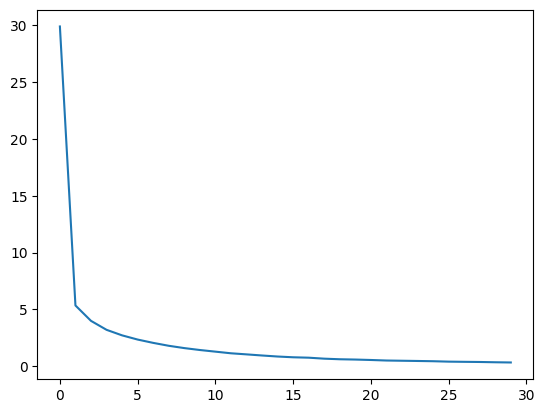

In [168]:
plt.plot(training_loss)

# save

In [23]:
from torchlake.common.controller.weight_manager import WeightManager

In [24]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{epoch}.mse.pth").as_posix())

In [26]:
model_path = manager.get_filename(
    detector_name=CONTEXT.detector_name,
    backbone_name=backbone.network_name,
    # epoch=recorder.current_epoch,
    epoch=30,
)

In [27]:
model_path

WindowsPath('../../artifacts/yolov2/yolov2.resnet34.30.mse.pth')

In [173]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.30.mse.pth, model size is 176.41MiB


In [28]:
manager.load_weight(model_path, model)

# Inference

In [29]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [176]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [177]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [178]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="yolo",
    #     # min_area=1024,
    #     # min_visibility=0.3,
    # ),
)

In [179]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [180]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [181]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [182]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [183]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B x (?, 25)
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/77 [00:01<?, ?it/s]


In [184]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     decoded = decoder.decode(output.cpu(), (224, 224))
#     boxes = decoded[0]
#     # boxes = output[0].unflatten(0, (5, 25)).permute(0, 2, 3, 1).reshape(-1, 25)
#     print(boxes[boxes[:, 4] > 0.1])

In [185]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

person: 0.32
person: 0.31
person: 0.36
person: 0.50
chair: 0.48
chair: 0.44
chair: 0.61
diningtable: 0.66
pottedplant: 0.50
bicycle: 0.53
person: 0.59
person: 0.49
person: 0.52
person: 0.47
person: 0.42
person: 0.60
person: 0.50
horse: 0.79
person: 0.38
sheep: 0.56
sheep: 0.65
sheep: 0.69
diningtable: 0.34
person: 0.64
person: 0.38
person: 0.73
person: 0.68
diningtable: 0.49
person: 0.42
person: 0.65
person: 0.76
horse: 0.79
person: 0.41
cat: 0.45
cow: 0.38
person: 0.37
person: 0.39
person: 0.42
sofa: 0.49
bicycle: 0.48
person: 0.44
person: 0.39
person: 0.75
car: 0.47
bus: 0.61
horse: 0.76
aeroplane: 0.57
car: 0.70
car: 0.54
car: 0.30
person: 0.54
person: 0.32
person: 0.46
person: 0.32
car: 0.78
car: 0.36
dog: 0.81
dog: 0.57
person: 0.37
train: 0.62
train: 0.66
car: 0.36
person: 0.63
person: 0.58
pottedplant: 0.51
car: 0.66
car: 0.48
car: 0.39
person: 0.33
person: 0.46
person: 0.45
person: 0.35
car: 0.60
sofa: 0.60
car: 0.56
car: 0.73
tvmonitor: 0.83
dog: 0.51
sofa: 0.46
horse: 0.38
pe

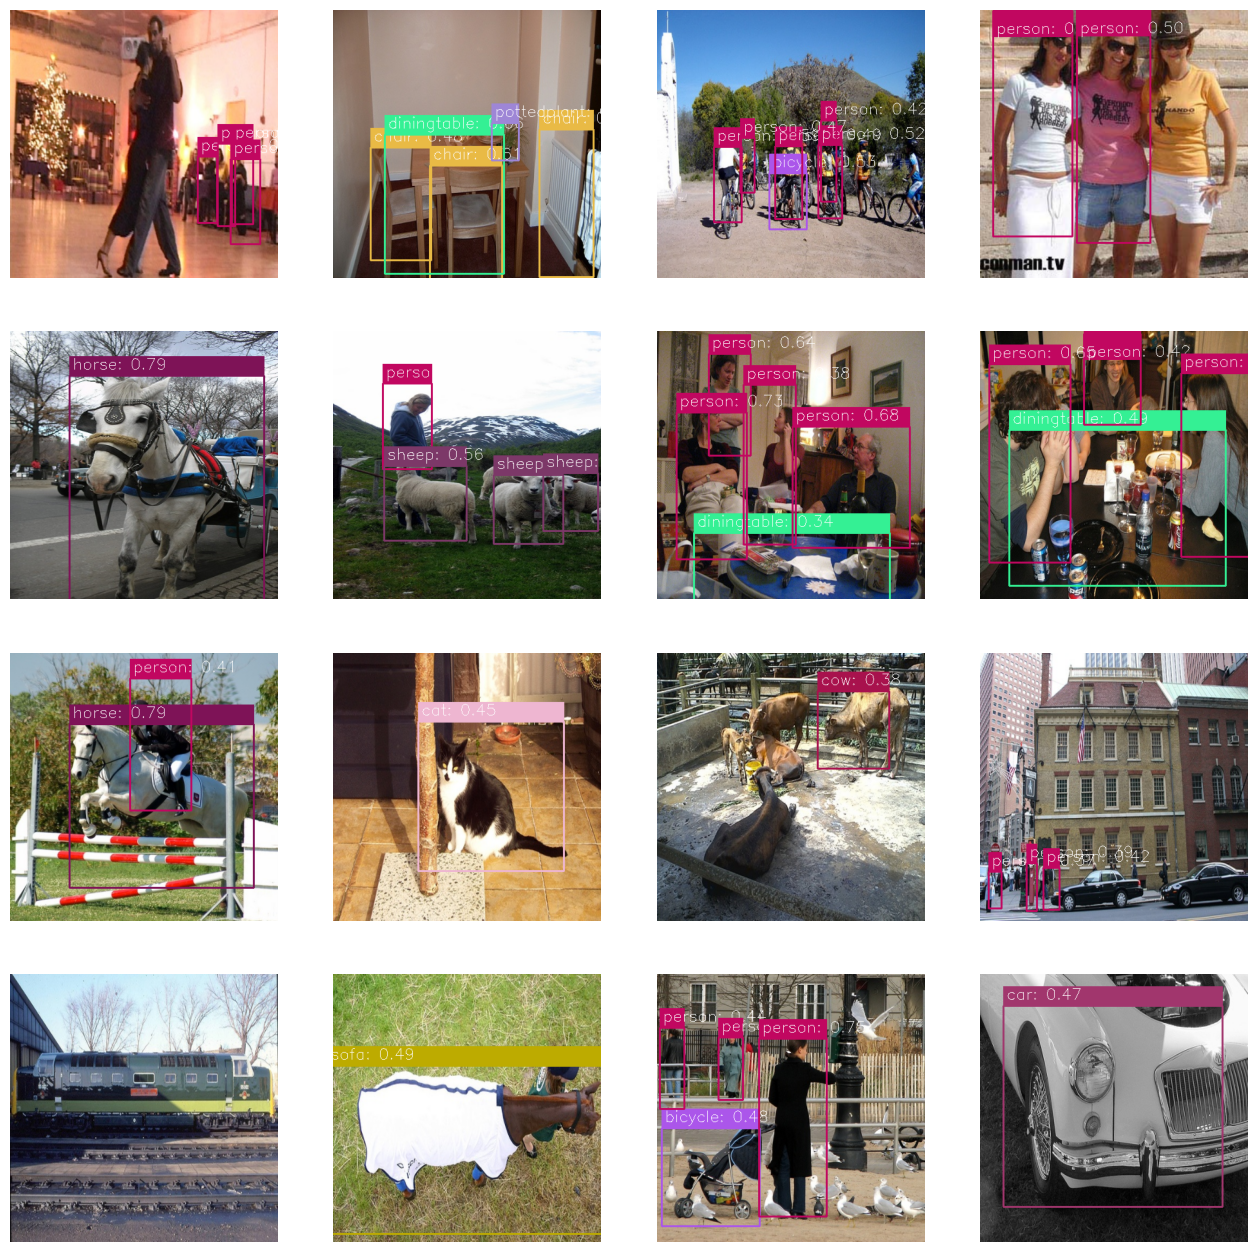

In [186]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [187]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.62
person: 0.70
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 0.34
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.61
aeroplane: 0.32
aeroplane: 0.33
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 3


In [188]:
# predictor.predict_video_file(
#     model,
#     "../../data/movie.mp4",
#     VOC_CLASS_NAMES,
#     color_map,
#     test_transform,
#     show=False,
#     save_dir=artifact_path.as_posix(),
# )

# evaluate

In [30]:
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [39]:
VAL_IMAGE_SIZE = 416

In [40]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [41]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [42]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [43]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [44]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    # shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [45]:
evaluator = Evaluator(CONTEXT)

In [46]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [02:41<00:00,  2.07s/it]


       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.413541  0.494392  0.504181  0.423978  0.404249  0.410039  0.423162   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.500802  0.417228  0.416242  ...  0.493054  0.497762  0.501106   

          person pottedplant    sheep      sofa     train tvmonitor     all  
AP@0.5  0.498538     0.49448  0.49502  0.494484  0.496456  0.495961  0.4647  

[1 rows x 21 columns]


In [47]:
result_table.T

,AP@0.5
aeroplane,0.413541
bicycle,0.494392
bird,0.504181
boat,0.423978
bottle,0.404249
bus,0.410039
car,0.423162
cat,0.500802
chair,0.417228
cow,0.416242


# further evaluation

# debug

## draw anchors

In [ ]:
VAL_IMAGE_SIZE = 448


In [ ]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [ ]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=test_transform,
)

In [ ]:
if not (Path(CONTEXT.anchors_path).exists() and Path(CONTEXT.anchors_path).is_file()):
    p = PriorBox(CONTEXT)
    anchors = p.build_anchors(train_dataset.table[["w", "h"]].to_numpy())
    p.save_anchors(anchors)

gt shape:  torch.Size([40058, 2])
init evaluation score: 0.5392965972423553
new evaluation score: 0.6193487286567688
new evaluation score: 0.6234176397323609
final mean IOU:  0.6234176397323609
member count of each group:  [9433, 9516, 6684, 5541, 8884]


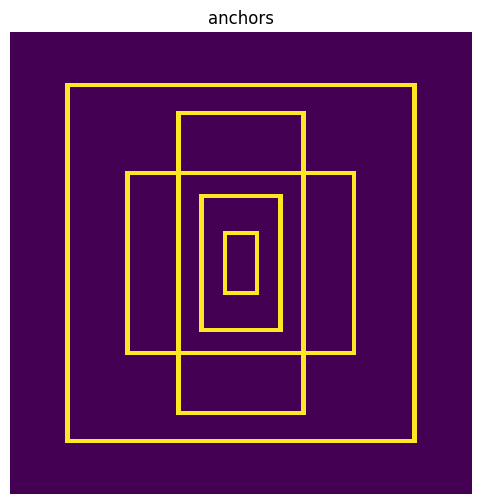

In [ ]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.yolov2 import PriorBox
from torchlake.object_detection.utils.config import load_anchors
from torchlake.common.utils.plot import plot_grids

box = PriorBox(CONTEXT)
anchors = load_anchors(CONTEXT.anchors_path)

canvas = [draw_anchors(anchors)]

plot_grids(
    canvas,
    ["anchors"],
    1,
    1,
    figsize=(8,6),
)

## match

In [ ]:
from torchlake.object_detection.utils.train import build_flatten_targets
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.object_detection.utils.plot import draw_label
from torchlake.object_detection.utils.train import generate_grid_train

In [ ]:
criterion = YOLOV2Loss(CONTEXT)

In [ ]:
for x, y in train_loader:
    break

In [ ]:
t, span = build_flatten_targets(y, (13, 13), delta_coord=True)

In [ ]:
cloned_image = img_tensor_to_np(x[0])

In [ ]:
matched = criterion.match(t.to(CONTEXT.device), span, 13, 13)

In [ ]:
matched[0].reshape(-1, 7).shape

torch.Size([845, 7])

In [ ]:
# candidate index among A*H*W
candidates = torch.arange(845).to(CONTEXT.device)[matched[0, :, 6] == 1]

In [ ]:
# anchor matched target
matched_gts =  matched[0, matched[0, :, 6] == 1, :]

In [ ]:
anchors_no, cells_no = candidates // (13 * 13), candidates % (13*13)
anchors_no, cells_no

(tensor([0, 0, 0, 0, 2, 2], device='cuda:0'),
 tensor([ 67, 132, 137, 140,  99, 110], device='cuda:0'))

In [ ]:
anchors_cxcy = generate_grid_train(13, 13, center=True).permute(0, 1, 3, 4, 2).reshape(-1, 2).repeat(CONTEXT.num_anchors, 1).to(CONTEXT.device)

In [ ]:
matched_anchors = criterion.anchors[:, anchors_no].permute(0, 1, 3, 4, 2).reshape(-1, 2)

In [ ]:
anchors_cxcy = anchors_cxcy[(anchors_no*13**2+cells_no).long()]
anchors_xy = anchors_cxcy - matched_anchors / 2
matched_anchors = torch.cat([anchors_xy, matched_anchors], -1)

In [ ]:
matched_anchors

tensor([[0.0608, 0.2067, 0.2630, 0.4328],
        [0.0608, 0.5913, 0.2630, 0.4328],
        [0.4454, 0.5913, 0.2630, 0.4328],
        [0.6762, 0.5913, 0.2630, 0.4328],
        [0.5937, 0.4739, 0.1203, 0.2060],
        [0.4398, 0.5509, 0.1203, 0.2060]], device='cuda:0')

In [ ]:
matched_gts[:, 2:4] = matched_gts[:, 2:4].exp() * matched_anchors[:, 2:4]
matched_gts[:, :2] = matched_gts[:, :2] + (matched_anchors[:, :2] - 0.5 /13) # - matched_gts[:, 2:4]/2 

In [ ]:
matched_gts

tensor([[ 0.0645,  0.2336,  0.2213,  0.4320, 14.0000,  0.7496,  1.0000],
        [ 0.0525,  0.5836,  0.3680,  0.4000,  1.0000,  0.6752,  1.0000],
        [ 0.4311,  0.5606,  0.2240,  0.4420, 14.0000,  0.7483,  1.0000],
        [ 0.6978,  0.5556,  0.3360,  0.4560, 14.0000,  0.6738,  1.0000],
        [ 0.6052,  0.4360,  0.1520,  0.2820, 14.0000,  0.5783,  1.0000],
        [ 0.4078,  0.5200,  0.0400,  0.1420, 14.0000,  0.2291,  1.0000]],
       device='cuda:0')

In [ ]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_gts[:, :4], torch.zeros(num_gt, 1).to(CONTEXT.device)], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0,128,128), "anchor": (128, 0, 0)},
    class_show=False,
)

In [ ]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_anchors[:, :4], torch.ones(num_gt, 1).to(CONTEXT.device)], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0,128,128), "anchor": (128, 0, 0)},
    class_show=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


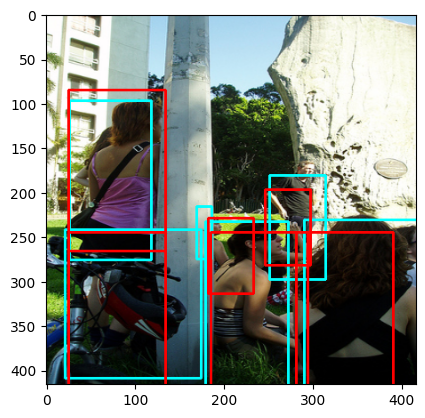

In [ ]:
plt.imshow(cloned_image)